# Previsão de Preços de Ações da Petrobras com Redes Neurais Recorrentes

Projeto prático que combina inteligência artificial e finanças para prever os preços das ações da Petrobras. Este é um tópico relevante, pois a capacidade de prever com precisão os movimentos do mercado financeiro é fundamental para investidores e tomadores de decisão. Para realizar essa tarefa, utilizamos uma técnica de aprendizado profundo conhecida como Redes Neurais Recorrentes (RNN).

## Coleta de Dados:
Começamos nossa jornada coletando dados históricos das ações da Petrobras. Utilizamos a biblioteca yfinance para buscar dados de preço de abertura, preço máximo, preço mínimo, preço de fechamento, preço ajustado e volume de negociações. O período de dados abrangeu de 2013 a 2021.


In [49]:
import yfinance as yf
import pandas as pd

# Defina o ticker da Petrobras
ticker = "PETR4.SA"  # Use "PETR4.SA" para as ações preferenciais da Petrobras

# Baixe os dados usando yfinance
data = yf.download(ticker, start="2013-01-02", end="2023-09-17")

# Selecione as colunas desejadas
selected_columns = ["Open", "High", "Low", "Close", "Adj Close", "Volume"]

# Crie um DataFrame com as colunas selecionadas
df = data[selected_columns]

# Resetar o índice para que a coluna "Date" seja uma coluna regular
df.reset_index(inplace=True)

# Exiba o DataFrame
print(df)


[*********************100%%**********************]  1 of 1 completed
           Date       Open       High        Low      Close  Adj Close  \
0    2013-01-02  19.990000  20.209999  19.690001  19.690001   6.423763   
1    2013-01-03  19.809999  20.400000  19.700001  20.400000   6.655396   
2    2013-01-04  20.330000  20.620001  20.170000  20.430000   6.665184   
3    2013-01-07  20.480000  20.670000  19.950001  20.080000   6.550999   
4    2013-01-08  20.110001  20.230000  19.459999  19.500000   6.361776   
...         ...        ...        ...        ...        ...        ...   
2657 2023-09-11  33.470001  33.689999  33.330002  33.369999  33.369999   
2658 2023-09-12  33.549999  33.779999  33.490002  33.529999  33.529999   
2659 2023-09-13  33.650002  33.700001  33.029999  33.029999  33.029999   
2660 2023-09-14  33.099998  34.000000  33.099998  33.869999  33.869999   
2661 2023-09-15  33.869999  33.990002  33.610001  33.889999  33.889999   

        Volume  
0     30182600  
1     30

## Exploração Inicial:
Após a coleta de dados, realizamos uma exploração inicial para entender a qualidade e a tendência dos dados. Identificamos a presença de valores ausentes (NaN) e decidimos lidar com eles, removendo as linhas correspondentes.

In [50]:
df[df.isna().any(axis=1)] #verifica qual linha é

df = df.dropna()
len(df)

2662

In [51]:
prices = df['Close']

## Visualização de Dados:
Para compreender melhor os movimentos dos preços das ações da Petrobras, criamos visualizações gráficas. Um gráfico de linhas mostrou a evolução dos preços de fechamento ao longo do tempo, destacando as fases de treinamento e teste dos dados.

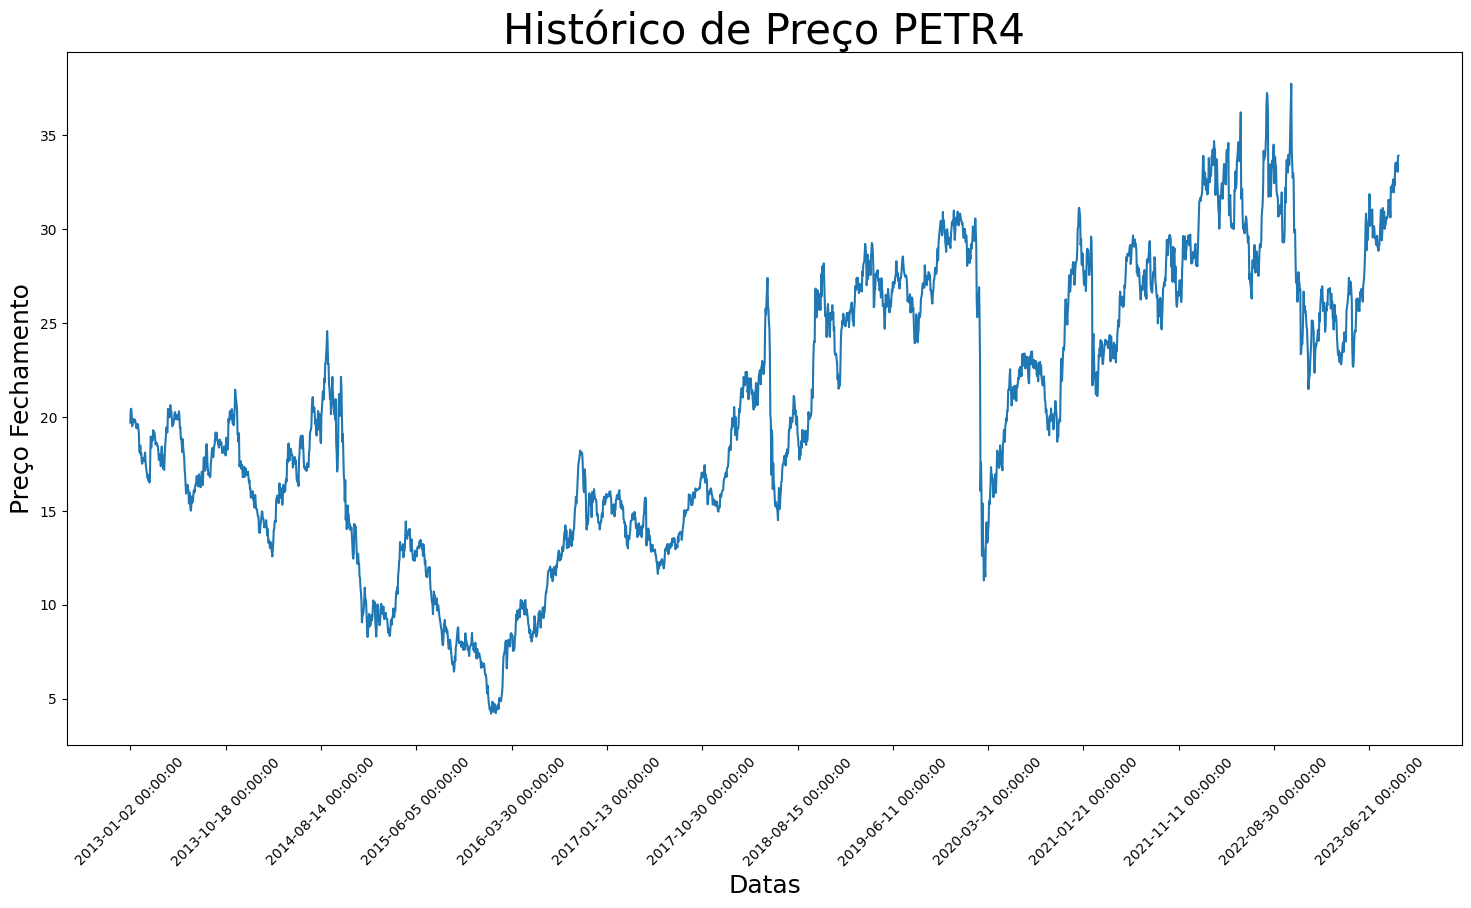

In [52]:
import matplotlib.pyplot as plt

plt.figure(figsize = (18,9))
plt.plot(df['Close'])
plt.xticks(range(0,df.shape[0],200), df['Date'].loc[::200], rotation=45)
plt.xlabel('Datas', fontsize=18)
plt.ylabel('Preço Fechamento', fontsize=18)
plt.title("Histórico de Preço PETR4", fontsize=30)
plt.show()



In [53]:
days_time_step = 15  # Define o tamanho do intervalo de tempo em dias

import numpy as np  # Importa a biblioteca NumPy para manipulação de arrays

# Calcula o tamanho dos dados de treinamento e teste
training_size = int(len(prices) * 0.95)  # Define o tamanho dos dados de treinamento como 95% do tamanho total
test_size = len(prices) - training_size  # Define o tamanho dos dados de teste como o complemento do tamanho de treinamento

# Cria arrays NumPy com os dados de treinamento e entrada
train_data = np.array(prices[0:training_size])  # Armazena os dados de treinamento, que vão desde o início até training_size
input_data = np.array(prices[training_size - days_time_step:])  # Armazena os dados de entrada, que começam days_time_step dias antes do início dos dados de treinamento

# Cria um array NumPy com os dados de teste
test_data = np.array(prices[training_size:])  # Armazena os dados de teste, que vão desde o final dos dados de treinamento até o final do conjunto de dados original

# Verifica o formato (shape) dos arrays de treinamento e teste
train_data.shape, test_data.shape


((2528,), (134,))

Visualização dos daos de treino e teste

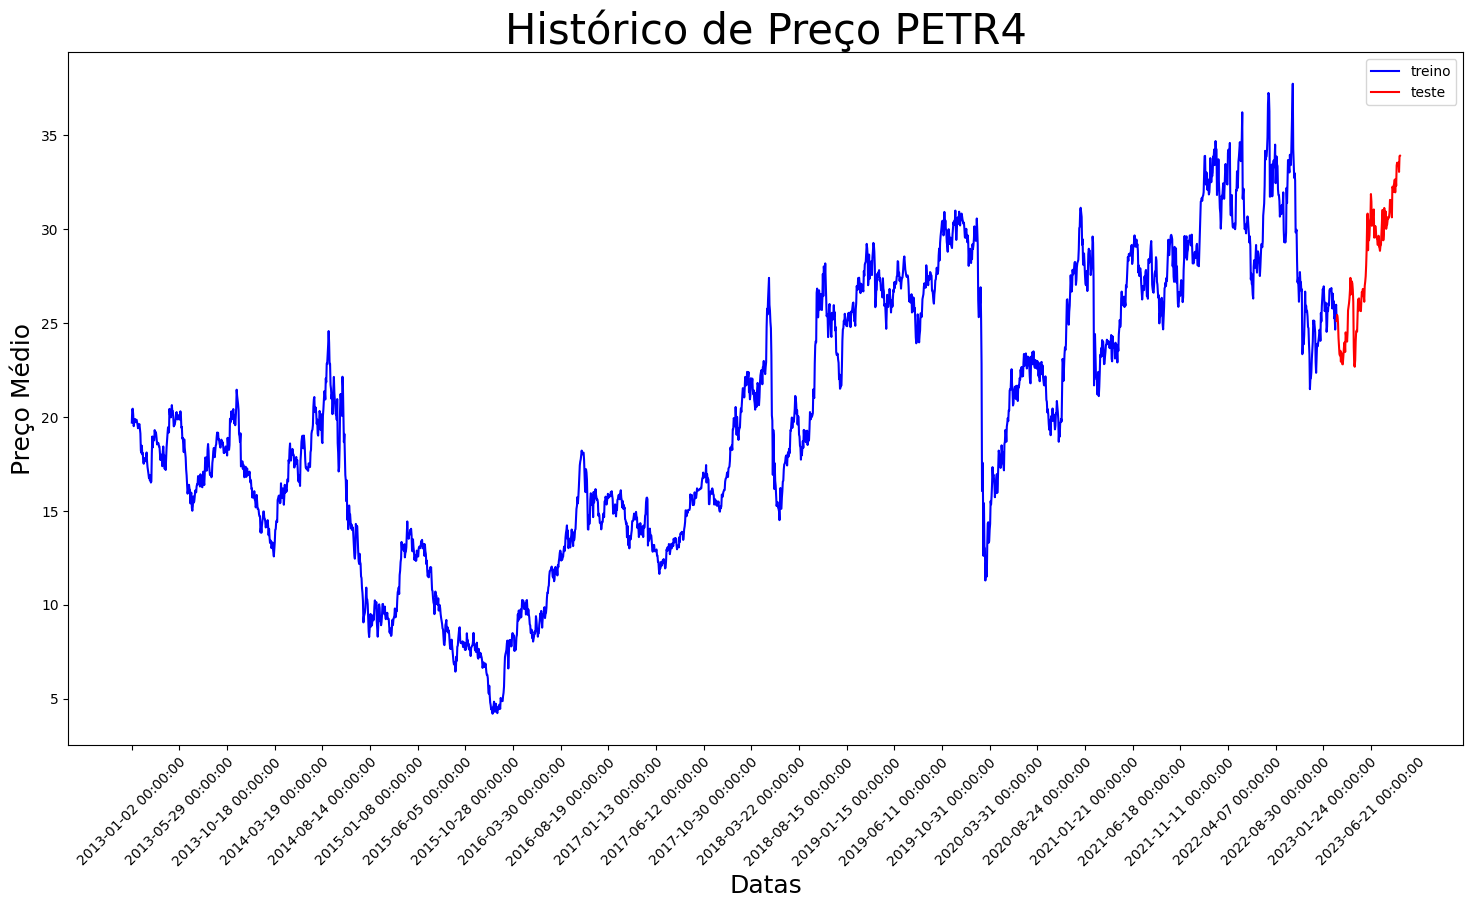

In [54]:
import matplotlib.pyplot as plt

plt.figure(figsize = (18,9))
plt.plot(df['Close'].loc[0:train_data.shape[0]], color = 'blue', label = 'treino')
plt.plot(df['Close'].loc[train_data.shape[0]:], color = 'red', label = 'teste')
plt.xticks(range(0,df.shape[0],100), df['Date'].loc[::100], rotation=45)
plt.xlabel('Datas', fontsize=18)
plt.ylabel('Preço Médio', fontsize=18)
plt.title("Histórico de Preço PETR4", fontsize=30)
plt.legend()
plt.show()

## Normalização dos dados

A normalização dos dados é uma etapa de pré-processamento de dados comumente usada em treinamentos de Redes Neurais Recorrentes (RNNs) para previsão de séries temporais, a normalização é essencial porque ajuda a estabilizar o treinamento da rede, tornando os dados de entrada consistentes em termos de escala. Isso é importante porque as RNNs são sensíveis à escala dos dados e podem ter dificuldades em convergir se os valores forem muito grandes ou muito pequenos. Portanto, normalizar os dados para um intervalo específico, como 0 a 1, é uma prática comum para melhorar o desempenho e a estabilidade do treinamento de RNNs em problemas de previsão de séries temporais, como a previsão de preços de ações.

In [55]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
train_data_norm = scaler.fit_transform(np.array(train_data).reshape(-1,1))
test_data_norm = scaler.transform(np.array(input_data).reshape(-1,1))
val_data_norm = scaler.transform(np.array(test_data).reshape(-1,1))

train_data_norm



array([[0.46211217],
       [0.48329353],
       [0.48418854],
       ...,
       [0.60978516],
       [0.64140812],
       [0.64916463]])

## Divisão do Dataset

In [56]:
#treino
X_train, y_train = [], []
for i in range(days_time_step, len(train_data)):
    X_train.append(train_data_norm[i-days_time_step:i])
    y_train.append(train_data_norm[i])

#teste
X_test = []
for i in range(days_time_step, days_time_step + len(test_data)):
    X_test.append(test_data_norm[i-days_time_step:i])

#val
X_val, y_val = [], []
for i in range(days_time_step, len(test_data)):
    X_val.append(val_data_norm[i-days_time_step:i])
    y_val.append(val_data_norm[i])

#converter tudo pra matriz numpy
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
X_val = np.array(X_val)
y_val = np.array(y_val)

X_test.shape

(134, 15, 1)

## Modelo RNN

**model = Sequential()**: Esta linha cria um objeto de modelo sequencial. O modelo sequencial é uma pilha linear de camadas onde você adiciona uma camada após a outra. É comumente usado para criar modelos de redes neurais feedforward e também pode ser usado para RNNs.

**model.add(SimpleRNN(100, return_sequences=False, input_shape=(days_time_step, 1)))**: Adicionando uma camada de RNN simples ao modelo. Esta camada tem os seguintes parâmetros:
* 100: Isso define o número de unidades (neurônios) na camada RNN. Essa camada possui 100 unidades, o que significa que terá 100 neurônios RNN.
* return_sequences=False: Isso significa que a camada RNN não retornará sequências completas. Em vez disso, ela retornará apenas a saída da última etapa de tempo (última unidade de tempo) para a próxima camada.
* input_shape=(days_time_step, 1): Esta linha define a forma da entrada que a camada RNN espera. days_time_step representa o número de etapas de tempo em uma sequência (ou seja, quantos dias você está usando como entrada), e 1 representa que cada etapa de tempo tem uma única característica (um valor de preço de ação).

**model.add(Dense(1))**: Adicionando uma camada densa (fully connected) com uma única unidade. Essa camada é usada para produzir a saída final do modelo, que é uma previsão única. Esta camada é típica em problemas de regressão, onde você deseja prever um valor contínuo.

**model.compile(loss='mse', optimizer='adam')**: Esta linha compila o modelo. Você está configurando três coisas importantes aqui:
loss='mse': Isso define a função de perda usada durante o treinamento do modelo. Neste caso, está sendo usada a função de erro quadrático médio (Mean Squared Error - MSE), que é comum em problemas de regressão.
optimizer='adam': Isso define o otimizador usado para ajustar os pesos do modelo durante o treinamento. O "Adam" é um otimizador muito usado devido à sua eficácia geral.


In [57]:
import tensorflow as tf

tf.__version__

'2.13.0'

In [58]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN

model = Sequential()
model.add(SimpleRNN(100, return_sequences=False, input_shape=(days_time_step, 1)))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_2 (SimpleRNN)    (None, 100)               10200     
                                                                 
 dense_2 (Dense)             (None, 1)                 101       
                                                                 
Total params: 10301 (40.24 KB)
Trainable params: 10301 (40.24 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [59]:
h = model.fit(X_train, y_train, validation_data = (X_val, y_val), epochs=30, batch_size=32)

Epoch 1/30
79/79 [==============================] - 2s 9ms/step - loss: 0.0200 - val_loss: 0.0011
Epoch 2/30
79/79 [==============================] - 0s 6ms/step - loss: 0.0011 - val_loss: 0.0016
Epoch 3/30
79/79 [==============================] - 0s 6ms/step - loss: 9.6490e-04 - val_loss: 0.0014
Epoch 4/30
79/79 [==============================] - 1s 8ms/step - loss: 8.7142e-04 - val_loss: 8.6594e-04
Epoch 5/30
79/79 [==============================] - 1s 10ms/step - loss: 8.2961e-04 - val_loss: 9.3298e-04
Epoch 6/30
79/79 [==============================] - 1s 9ms/step - loss: 7.7765e-04 - val_loss: 8.7598e-04
Epoch 7/30
79/79 [==============================] - 1s 9ms/step - loss: 7.3793e-04 - val_loss: 6.9890e-04
Epoch 8/30
79/79 [==============================] - 1s 8ms/step - loss: 6.8915e-04 - val_loss: 9.8052e-04
Epoch 9/30
79/79 [==============================] - 0s 6ms/step - loss: 6.7825e-04 - val_loss: 6.5841e-04
Epoch 10/30
79/79 [==============================] - 0s 6ms/step 

## Avaliação do modelo

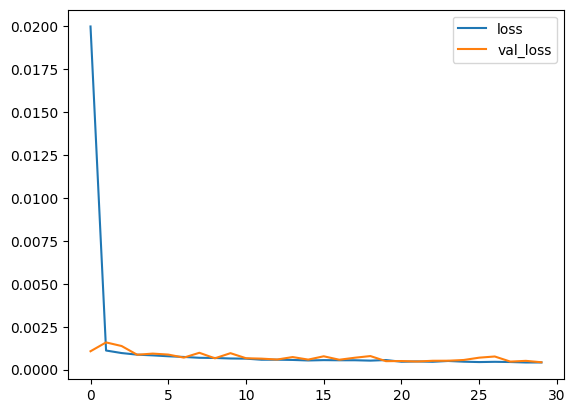

In [60]:
import matplotlib.pyplot as plt

plt.plot(h.history["loss"], label='loss')
plt.plot(h.history["val_loss"], label='val_loss')
plt.legend()

## Previsão

In [61]:
#predição de valores pela rede
predict = model.predict(X_test)

#transformação inversa do normalizador, pra que possamos plotar no gráfico os resultados
predict = scaler.inverse_transform(predict)
real = test_data

predict.shape

5/5 [==============================] - 0s 3ms/step


(134, 1)

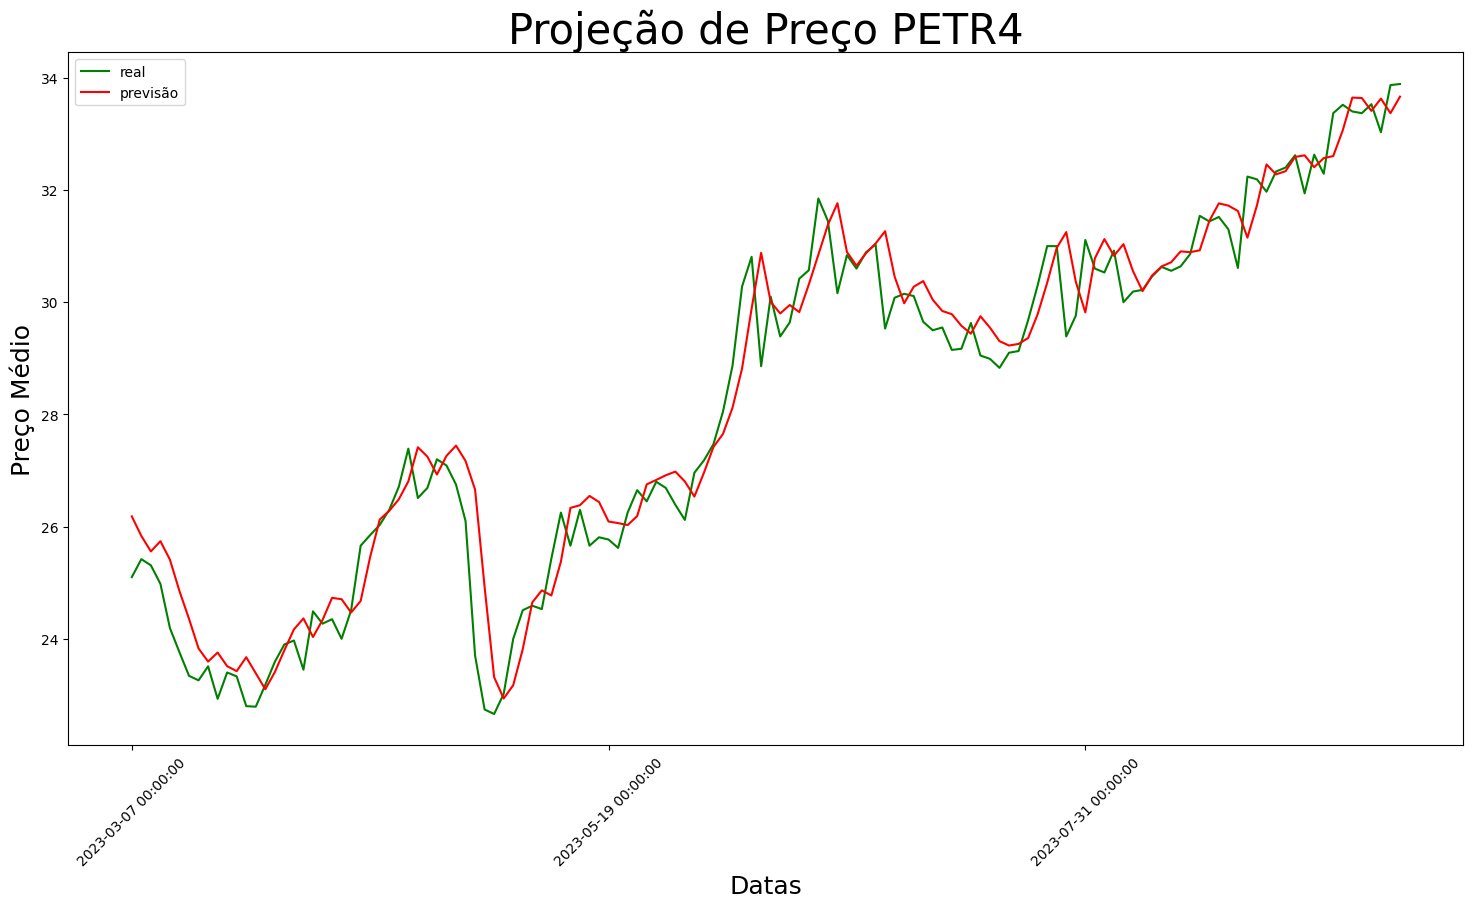

In [62]:
import matplotlib.pyplot as plt

plt.figure(figsize = (18,9))
plt.plot(real, color = 'green', label = 'real')
plt.plot(predict, color = 'red', label = 'previsão')
plt.xticks(range(0, len(real), 50), df['Date'].iloc[- len(real)::50], rotation=45)
plt.xlabel('Datas', fontsize=18)
plt.ylabel('Preço Médio', fontsize=18)
plt.title("Projeção de Preço PETR4", fontsize=30)
plt.legend()
plt.show()

In [63]:
import math
from sklearn.metrics import mean_squared_error
mean_squared_error(real, predict)

0.4862931542748852

In [64]:
# Supondo que o último dia disponível seja o dia 17
# Crie um novo conjunto de dados de entrada para o dia 18
new_input_data = test_data[-days_time_step:]  # Pegue os últimos 15 dias até o dia 17

# Normalize os novos dados de entrada
new_input_data_norm = scaler.transform(np.array(new_input_data).reshape(-1, 1))

# Faça uma previsão com base nos novos dados de entrada
new_prediction_norm = model.predict(np.array([new_input_data_norm]))

# Inverta a normalização da previsão para obter o valor de preço em escala original
new_prediction = scaler.inverse_transform(new_prediction_norm)

# Imprima a previsão para o dia 18
print("Previsão para o Dia 18:", new_prediction[0][0])


1/1 [==============================] - 0s 65ms/step
Previsão para o Dia 18: 34.048317
